In [1]:
%matplotlib inline
%config InlineBackend.figure_formats =['svg']

import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [4]:
df1 = pd.read_csv('../data/BCHAIN-MKPRU.csv',parse_dates=['Date'],index_col=0)
second_column_name1 = df1.columns[0]
df1[second_column_name1].fillna(method='ffill', inplace=True)
df2 = pd.read_csv('../data/LBMA-GOLD.csv',parse_dates=['Date'],index_col=0)
second_column_name2 = df2.columns[0]
df2[second_column_name2].fillna(method='ffill', inplace=True)

df=df1.copy()
df[second_column_name2]=df2[second_column_name2].copy()
df[second_column_name2].fillna(method='ffill',inplace=True)
df[second_column_name2].fillna(method='bfill',inplace=True)

In [5]:
all_data_array=df.values
all_data_array.shape

(1826, 2)

In [6]:
train_max=np.max(all_data_array,axis=0).reshape(1,2).copy()
train_min=np.min(all_data_array,axis=0).reshape(1,2).copy()
all_data_array=(all_data_array-train_min)/(train_max-train_min)

In [7]:
train_max,train_min

(array([[63554.44,  2067.15]]), array([[ 594.08, 1125.7 ]]))

In [8]:
PREDICT_DAY=7
BEFORE_DAY=400
EPOCH=50
LR=1e-3/2

In [9]:
train_x_data_array=np.zeros(shape=(all_data_array.shape[0]-PREDICT_DAY-BEFORE_DAY,BEFORE_DAY,2))

for i in range(all_data_array.shape[0]-PREDICT_DAY-BEFORE_DAY):
    train_x_data_array[i,:,:]=all_data_array[i:i+BEFORE_DAY]

In [10]:
train_x_data_array.shape

(1419, 400, 2)

In [11]:
train_y_data_array=np.zeros(shape=(all_data_array.shape[0]-PREDICT_DAY-BEFORE_DAY,PREDICT_DAY,2))

for i in range(all_data_array.shape[0]-PREDICT_DAY-BEFORE_DAY):
    train_y_data_array[i,:,:]=all_data_array[i+BEFORE_DAY:i+BEFORE_DAY+PREDICT_DAY]


In [12]:
train_y_data_array[0,:,:].shape,train_x_data_array[0,:,:].shape

((7, 2), (400, 2))

In [13]:
class Set(Dataset):
    def __init__(self, data, label):
        self.data, self.label = data,label

    def __getitem__(self, index):
        return torch.Tensor(self.data[index,:,:]).float(), torch.Tensor(self.label[index]).float()

    def __len__(self):
        return self.data.shape[0]

In [14]:
class LSTM(nn.Module):
    def __init__(self, day_predict):
        super(LSTM, self).__init__()

        self.lstm = nn.LSTM(
            input_size=2,
            hidden_size=128,
            num_layers=4,
            batch_first=True)

        self.out = nn.Sequential(
            nn.Linear(128, 2))

        self.day_predict = day_predict

    def forward(self, x):
        r_out, (_,_) = self.lstm(x, None)
        out = self.out(r_out[:, -self.day_predict:, :])

        return out

In [15]:
train_x_data_array[:1400].shape

(1400, 400, 2)

In [16]:
train_set=Set(train_x_data_array.copy(),train_y_data_array.copy())
train_loader=DataLoader(train_set,batch_size=64,shuffle=True)
tx,ty=next(iter(train_loader))
type(tx)

torch.Tensor

In [17]:
rnn = LSTM(PREDICT_DAY)

if torch.cuda.is_available():  # 是否使用gpu
    rnn = rnn.cuda()

optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
loss_func = nn.MSELoss()

best_loss = 1000

for step in range(EPOCH):
    for tx, ty in train_loader:
        if torch.cuda.is_available():
            tx = tx.cuda()
            ty = ty.cuda()

        output = rnn(tx)
        loss = loss_func(output, ty)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 20 == 0:
            print('epoch : %d  ' % step, 'train_loss : %.4f' % loss.cpu().item())

    scheduler.step()

epoch : 0   train_loss : 0.2352
epoch : 0   train_loss : 0.1895
epoch : 0   train_loss : 0.1841
epoch : 0   train_loss : 0.1543
epoch : 0   train_loss : 0.1645
epoch : 0   train_loss : 0.1139
epoch : 0   train_loss : 0.1614
epoch : 0   train_loss : 0.1257
epoch : 0   train_loss : 0.1003
epoch : 0   train_loss : 0.0749
epoch : 0   train_loss : 0.0775
epoch : 0   train_loss : 0.0645
epoch : 0   train_loss : 0.0627
epoch : 0   train_loss : 0.0681
epoch : 0   train_loss : 0.0727
epoch : 0   train_loss : 0.0817
epoch : 0   train_loss : 0.0680
epoch : 0   train_loss : 0.0618
epoch : 0   train_loss : 0.0521
epoch : 0   train_loss : 0.0676
epoch : 0   train_loss : 0.0514
epoch : 0   train_loss : 0.0552
epoch : 0   train_loss : 0.0303
epoch : 20   train_loss : 0.0024
epoch : 20   train_loss : 0.0020
epoch : 20   train_loss : 0.0024
epoch : 20   train_loss : 0.0032
epoch : 20   train_loss : 0.0021
epoch : 20   train_loss : 0.0017
epoch : 20   train_loss : 0.0017
epoch : 20   train_loss : 0.0019


In [18]:
predict_y_array_gold=[]
predict_y_array_bc=[]

for i in range(0,len(train_x_data_array)-PREDICT_DAY-BEFORE_DAY,PREDICT_DAY):
    predict_y=rnn(torch.unsqueeze(torch.Tensor(train_x_data_array[i,:,:]),dim=0).cuda())
    predict_y=torch.squeeze(predict_y.cpu()).detach().numpy()
    predict_y=predict_y*(train_max-train_min)+train_min
    predict_y_array_bc.append(predict_y[:,0])
    predict_y_array_gold.append(predict_y[:,1])


In [19]:
predict_y_array_bc=np.concatenate(predict_y_array_bc,axis=0)
predict_y_array_gold=np.concatenate(predict_y_array_gold,axis=0)
predict_y_array_bc.shape,predict_y_array_gold.shape

((1015,), (1015,))

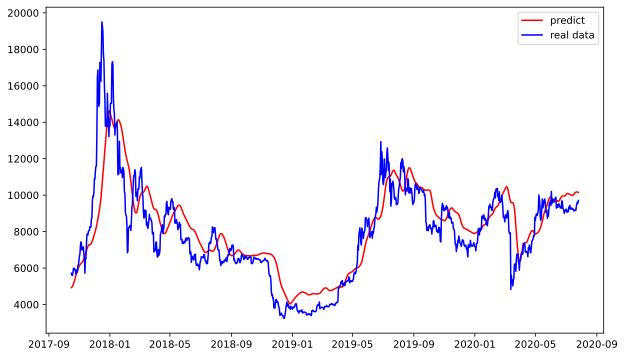

In [20]:
plt.figure(figsize=(10,6))
plt.plot(df.index[BEFORE_DAY:BEFORE_DAY+len(predict_y_array_bc)],
    predict_y_array_bc,'r',label='predict')
plt.plot(df.index[BEFORE_DAY:BEFORE_DAY+len(predict_y_array_bc)],
    df[second_column_name1][BEFORE_DAY:BEFORE_DAY+len(predict_y_array_bc)],'b',label='real data')
plt.legend()
plt.savefig('lstm_3_bc.pdf')
plt.show()

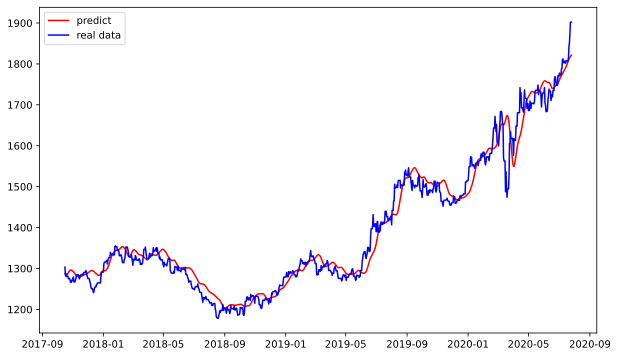

In [21]:
plt.figure(figsize=(10,6))
plt.plot(df.index[BEFORE_DAY:BEFORE_DAY+len(predict_y_array_bc)],
    predict_y_array_gold,'r',label='predict')
plt.plot(df.index[BEFORE_DAY:BEFORE_DAY+len(predict_y_array_bc)],
    df[second_column_name2][BEFORE_DAY:BEFORE_DAY+len(predict_y_array_bc)],'b',label='real data')
plt.legend()
plt.savefig('lstm_3_gold.pdf')
plt.show()

In [22]:
rnn=rnn.cpu()
torch.save(rnn,'multi_channel_lstm.pth')